# Stochastic SIS ABC fitting example

In [83]:
%pylab inline
import ABCPRC as prc
import seaborn as sns
import scipy.stats as stats

Populating the interactive namespace from numpy and matplotlib


## Create individual-based model

First create the Stochastic SIS model. Briefly, for $n$ individuals, each susceptible individual has a rate of becoming infected $\beta I/n$ and each infected individual can recover at rate $\gamma$.

Here we use a tau-step algorithm to generate a realisation of the SIS process, where for each time-step a Poisson number of infection and recovery events occur according to a Poisson distribution. A small fixed time-step `eps` is also defined.

The function `createData` generates a realisation of the stochastic process. The function `ibm` is what is fed into the ABC method. It does a transformation of the parameters from the infection time and $R_0$ to $\beta$ and $\gamma$. Importantly the output of the `ibm` function is a two-dimensional time-series representing the $I_{t+1} | I_t$ pairs from the realisation.
It also does a small amount of error handling for when the infected population dies out.

In [34]:
def createData(beta,gamma,n=100,T=100,I0=1):
    S,I = np.zeros(T),np.zeros(T)
    S[0] = n-I0
    I[0] = I0
    eps=0.1
    for i in np.arange(1,T):
        if beta*S[i-1]*I[i-1]/n<0: print(beta*S[i-1]*I[i-1]/n)
        infections = np.random.poisson(lam=eps*beta*S[i-1]*I[i-1]/n)
        recoveries = np.random.poisson(lam=eps*gamma*I[i-1])
        S[i] = np.max((0,S[i-1] - infections + recoveries))
        I[i] = np.max((0,I[i-1] + infections - recoveries))
        
    return S,I

def ibm(*ps):
    n=100
    gamma = 1./ps[1]
    beta = ps[0]*gamma
    
    S,I = createData(beta,gamma,n=n,T=100,I0=20)
    if I[-1]==0:
        return np.vstack((0*I[:-1],0*I[1:])).T
    else:
        return np.vstack((I[:-1],I[1:])).T

## Generate some fake data

Use the `ibm` function to create data for a specified $R_0$ and recovery time.

In [41]:
r0 = 1.5
rec_time = 1.
gamma = 1./rec_time
beta = r0*gamma 
xs = ibm(r0,gamma)

Check the shape of the output. $T=100$, so the number of pairs should be $T-1$ and the second dimension should be $2$

In [42]:
print(xs.shape)

(99, 2)


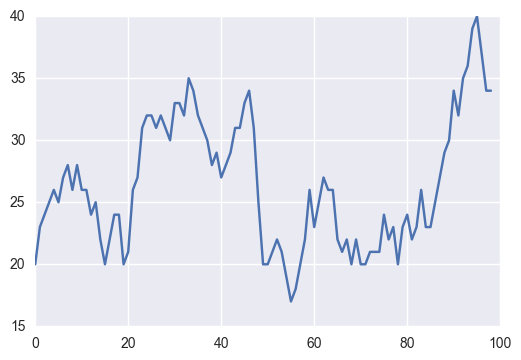

In [43]:
plt.plot(xs[:,0]);

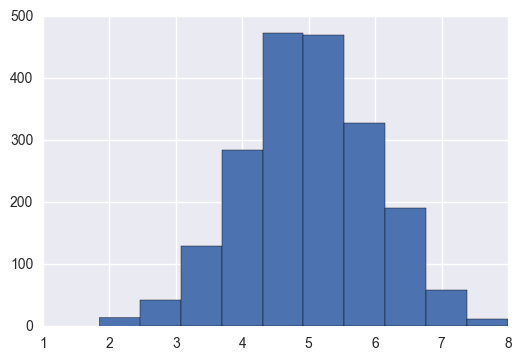

In [32]:
plt.hist(stats.norm(loc=5.,scale=1.).rvs(2000));

## Set-up model

In [78]:
m = prc.ABC()

We'll begin by misspecifying priors by having a uniform prior for $R_0$ and the revovery time that is a long way away from the true values. An error should raise that the prior is misspecified

In [72]:
wrong_priors = [stats.uniform(loc=0.,scale=0.1).rvs,stats.uniform(loc=5.,scale=0.1).rvs]
m.setup(modelFunc=ibm,xs=xs,priors=wrong_priors,method='Adaptive',toln=12)

m.run(10) 

tol[0] = 0.0


NameError: All initial tolerances are infinite. Either priors are misspecified or number of particles needs to be extended.

Let's try that again with properly specified priors that include the true value.

Here we define the method by calling the `ABC` class from the `prc` library. Priors are specified using the `scipy` stats package. In general priors are expected to be a list of functions where each function call returns a sample from the given parameter. The length of the prior list is used to determine the size of the inputs to the model. 

The method is set-up by specifying the model `modelFunc`, the data `xs`, the priors `priors`, the method and the number of tolerances to use in the method `toln`. 

The method is then ran using the method `run` for 100 particles.

In [84]:
m = prc.ABC()
priors = [stats.uniform(loc=0.,scale=2.).rvs,stats.uniform(loc=0.5,scale=2.).rvs]
m.setup(modelFunc=ibm,xs=xs,priors=priors,method='Adaptive',toln=10)

m.run(100) 

tol[0] = 0.0
Progress: [-------------] 0.0% tol[1] = 0.731468528305
Progress: [#------------] 7.7% tol[2] = 0.334443985845
Progress: [##-----------] 15.4% tol[3] = 0.209275756219
Progress: [###----------] 23.1% tol[4] = 0.137941951325
Progress: [####---------] 30.8% tol[5] = 0.102930336694
Progress: [#####--------] 38.5% tol[6] = 0.0843902741028
Progress: [######-------] 46.2% tol[7] = 0.0709904732944
Progress: [#######------] 53.8% tol[8] = 0.0637413195145
Progress: [########-----] 61.5% tol[9] = 0.0572663400478
Progress: [##########] 100.0% Done...



Print out the summary of the parameters (median and 95% lower and upper percentiles)

In [85]:
summary = m.fitSummary()

param 0 : 1.41162910382 (1.22529593459,1.65228702784) 
param 1 : 1.00542454787 (0.765517309038,1.29097897415) 


Plot the distribution of the particles

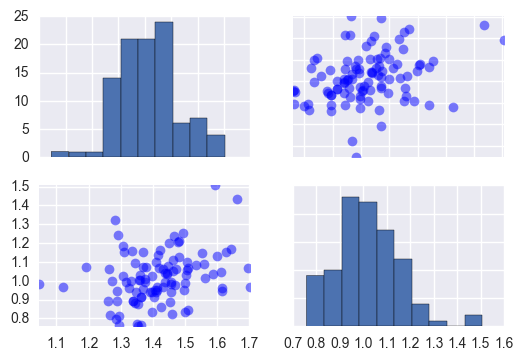

In [86]:
m.trace(plot=True)

## Conclusion

From the above diagram the method was able to correctly recover both parameters. The particles can be saved for future use using the `save` method. A sample from the posterior can also be taken by using the method `postSample`